In [7]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [8]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1NkFzQ5N-I1J34-0uStvw0xaPbntqk7AV',
dest_path='content/rosseman.zip',   
unzip=True)

In [9]:
# since the size of teras package is too big I have done Rnn in google collab.

In [10]:
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
!pip install mlflow
import mlflow.tensorflow
sns.set()

In [12]:
def read_csv(csv_path, missing_values=[]):
  """
  reads csv file
  """
  try:
    df = pd.read_csv(csv_path, na_values=missing_values)
    print("file read as csv")
    return df
  except FileNotFoundError:
    print("file not found")

In [13]:
df_train = read_csv("content/rossman data/train.csv")
test = read_csv("content/rossman data/test.csv")

file read as csv
file read as csv


In [14]:
# A quick view a data on hand
display(df_train.head())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [15]:
display(df_train.describe())


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


None

In [17]:
def get_feature(df):
  """
  gets date and sales column
  """
  return df[["Date", "Sales"]]

In [18]:
def drop_closed(df):
  """
  drops rows when open column is zero
  """
  df = df[df['Open'] == 1]
  return df

In [19]:

def scaler(df, columns, mode="minmax"):
  """
  scales using MinMax scaler
  """
  if (mode == "minmax"):
      minmax_scaler = MinMaxScaler()
      return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns), minmax_scaler
  elif (mode == "standard"):
      scaler = StandardScaler()
      return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler
  elif (mode == "robust"):
      scaler = RobustScaler()
      return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler

In [20]:
def add_scaled_sales(df):
  """
  adds scaled sales
  """
  scaled_sales, scaler_object = scaler(df[["Sales"]], mode="minmax", columns=["scaled_sales"])
  df["scaled_sales"] = scaled_sales["scaled_sales"].to_list()
  return df, scaler_object

In [21]:
def handle_outliers(df, col, method="lower_upper"):
  """
  handles outlier in the data
  """
        
  df = df.copy()
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)

  lower_bound = q1 - ((1.5) * (q3 - q1))
  upper_bound = q3 + ((1.5) * (q3 - q1))

  if method == "mean":
    df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
    df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

  elif  method == "mode":
    df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
    df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
  else:
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

  return df

In [22]:
df_train["Sales"] = df_train["Sales"].astype("float")

In [23]:
df_train = drop_closed(df_train)
df_train = get_feature(df_train)
df_train = handle_outliers(df_train, "Sales")

In [24]:
df_train_agg = df_train.groupby("Date").agg({"Sales": "mean"})
df_train_agg.describe()

,Sales
count,942.000000
mean,6988.142162
std,1475.510458
min,4057.782960
25%,5725.756766
50%,6822.535825
75%,7778.867102
max,11908.661883


In [25]:
def check_stationary(df, col):
  """
  checks stationary
  """
  adfResult = adfuller(df[col].values, autolag='AIC')
  print(f'ADF Statistic: {adfResult[0]}')
  print(f'p-value: {adfResult[1]}')
  return adfResult[1] >= 0.05

In [26]:
check_stationary(df_train_agg, "Sales")

ADF Statistic: -4.719271399336017
p-value: 7.741088433521528e-05


False

In [27]:

def difference(dataset, interval=1):
    differ = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        differ.append(value)
    return pd.Series(diff)

In [28]:
def corrPlots(array: np.array, is_partial=False):
    plt.figure(figsize=(30, 5))
    if (not is_partial):
        plot_acf(array)
    else:
        plot_pacf(array)
    plt.show()

<Figure size 2160x360 with 0 Axes>

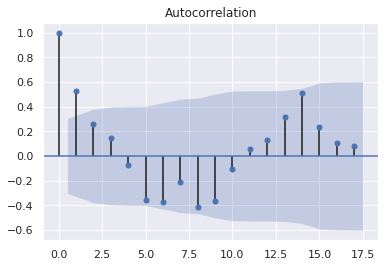

In [29]:
# Auto correlation
acfSalesScaled = acf(df_train_agg["Sales"].values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp)

<Figure size 2160x360 with 0 Axes>

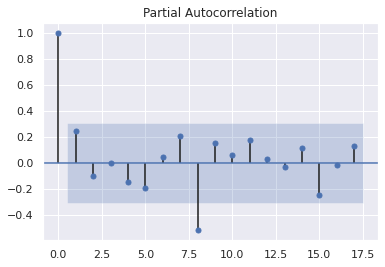

In [30]:
# partial correlation
pacfSalesScaled = pacf(df_train_agg["Sales"].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, is_partial=True)

In [31]:
scaled_df, scaler_obj = add_scaled_sales(df_train_agg)

In [32]:


class TimeSeriesSalsesPred:
    
    def __init__(self, WINDOW_SIZE, BATCH_SIZE, sales_data):
        self.WINDOW_SIZE = WINDOW_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        
        data_agg = sales_data.groupby("Date").agg({"Sales": "mean"})
        self.SIZE = len(data_agg["Sales"])

        self.scaled_df, self.scaler_obj = add_scaled_sales(data_agg)
        
        self.DateTrain = np.reshape(self.scaled_df.index.values[0:BATCH_SIZE], (-1, 1))
        self.DateValid = np.reshape(self.scaled_df.index.values[BATCH_SIZE:], (-1, 1))
        
        self.train_sales, self.valid_sales, self.TrainDataset, self.ValidDataset = self.prepare_data(WINDOW_SIZE,
                                                                                                     BATCH_SIZE, 
                                                                                                     self.scaled_df)
    
    def prepare_data(self, WINDOW_SIZE, BATCH_SIZE, scaled_df):
        train_sales = scaled_df["scaled_sales"].values[0:BATCH_SIZE].astype('float32')
        valid_sales = scaled_df["scaled_sales"].values[BATCH_SIZE:].astype('float32')
        TrainDataset = self.windowed_dataset(train_sales, WINDOW_SIZE, BATCH_SIZE)
        ValidDataset = self.windowed_dataset(valid_sales, WINDOW_SIZE, BATCH_SIZE)
        
        return train_sales, valid_sales, TrainDataset, ValidDataset
    
    def train(self, EPOCHS, verbose=1, ):
        
        mlflow.set_experiment('Rossman-' + 'Lstm_model')

        mlflow.tensorflow.autolog(every_n_iter=2,log_models=True)

        mlflow.end_run()
        with mlflow.start_run(run_name="Lstm_model-Base-line"):

            model = Sequential()
            model.add(LSTM(20, input_shape=[None, 1], return_sequences=True))
            model.add(LSTM(10, input_shape=[None, 1]))
            model.add(Dense(1))
            model.compile(loss="huber_loss", optimizer='adam')
            model.summary()

            history = model.fit(self.TrainDataset, epochs=EPOCHS, validation_data=self.ValidDataset, verbose=verbose)
        
        self.plot_history(history)
        
        
        return model, history
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(12, 9))
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="val_loss")
        plt.legend()
        plt.show()
        
        return fig
    
   
    def model_forecast_test(self, model):

        series = self.scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(self.WINDOW_SIZE))
        ds = ds.batch(self.SIZE).prefetch(1)
        forecast = model.predict(ds)
        
        Results = forecast[self.BATCH_SIZE-self.WINDOW_SIZE:-1]
        Results1 = self.scaler_obj.inverse_transform(Results.reshape(-1,1))
        XValid1 = self.scaler_obj.inverse_transform(self.valid_sales.reshape(-1,1))
        
        fig, MAE, RMSE = self.plot_forcast(Results, Results1, XValid1, self.DateValid, self.WINDOW_SIZE)
        
        
        return forecast, fig, MAE, RMSE
    
    def plot_forcast(self, Results, Results1, XValid1, DateValid,  WINDOW_SIZE):
        fig = plt.figure(figsize=(30, 8))
        plt.title("LSTM Model Forecast Compared to Validation Data")
        
        plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
        plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
        
        plt.xlabel('Date')
        plt.ylabel('Thousands of Units')
        plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
        plt.legend(loc="upper right")

        MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
        RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

        textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

        # place a text box in upper left in axes coords
        plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
        plt.grid(True)

        plt.show()
        
        return fig, MAE, RMSE
    
        
        

    
    def windowed_dataset(self, series, window_size, batch_size): 
        series = tf.expand_dims(series, axis=-1)
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

In [33]:
SIZE = len(df_train_agg["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

t = TimeSeriesSalsesPred(WINDOW_SIZE, BATCH_SIZE, df_train)

INFO: 'Rossman-Lstm_model' does not exist. Creating a new experiment
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0764 - val_loss: 0.0691
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.0693 - val_loss: 0.0623
Epoch 3/200
1/1 [==============================] - 0s 246ms/step - loss: 0.0625 - val_loss: 0.0559
Epoch 4/200
1/1 [=======

INFO:tensorflow:Assets written to: /tmp/tmprz321avz/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmprz321avz/model/data/model/assets


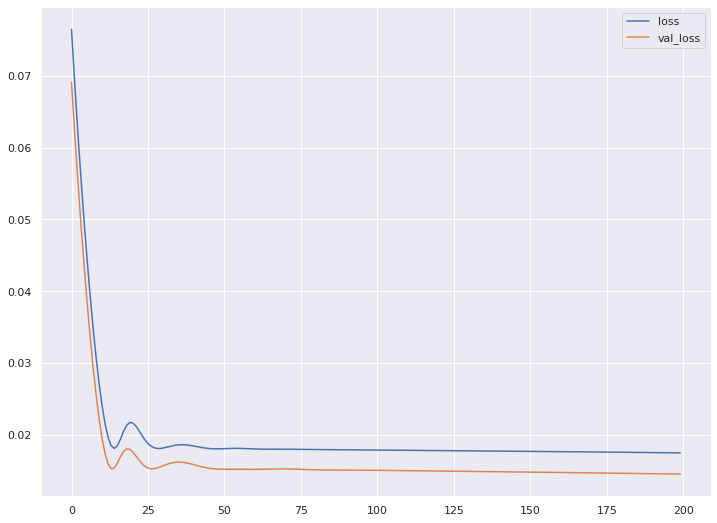

In [35]:
model2, his = t.train(EPOCHS)